In [342]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [343]:
import googlemaps


In [344]:
import gmaps as gm

In [367]:
subte = pd.read_csv('../data/varios/estaciones-de-subte.csv',delimiter=',')
metrobus = pd.read_csv('../data/varios/estaciones-de-metrobus.csv',delimiter=';')
ferrocarril = pd.read_csv('../data/varios/estaciones-de-ferrocarril.csv',delimiter=';')

In [368]:
def subte_color(linea):
    if (linea == 'A'): return 'c'
    if linea == 'B' : return 'r'
    if linea == 'C': return 'b'
    if linea == 'D' :return 'g'
    if linea == 'E' :return 'm'
    if linea == 'H' :return '#FFFF00'

In [369]:
subte['color'] = subte.LINEA.apply(subte_color)

In [370]:
subte.rename(columns={'X':'lon','Y':'lat'},inplace=True)

In [371]:
metrobus.rename(columns={'X':'lon','Y':'lat'},inplace=True)

In [372]:
ferrocarril.rename(columns={'LNG':'lon','LAT':'lat'},inplace=True)

In [373]:
ferrocarril['color'] = '#000000'

In [374]:
metrobus['color'] = '#00FF00'

In [375]:
max_lat = ferrocarril['lat'].max()
min_lat = ferrocarril['lat'].min()

max_lon = ferrocarril['lon'].max()
min_lon = ferrocarril['lon'].min()

In [376]:
subte = subte.append(subte)

In [377]:
df = subte

In [378]:
for i in xrange(0,5):
    df = df.append(metrobus)
    df = df.append(ferrocarril)
    df = df.append(subte)

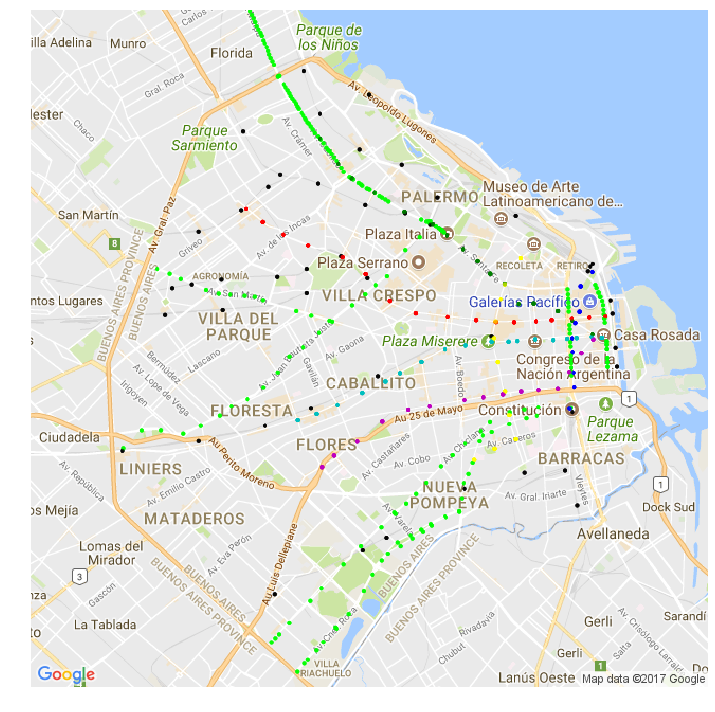

In [379]:
gm.scatter(latitudes=df.lat, longitudes=df.lon,colors=df.color)

In [380]:
properties = pd.read_csv('../data/properati_full_month.csv')

In [381]:
properties = properties[properties['state_name'] == 'Capital Federal']

In [382]:
properties = properties[pd.notnull(properties['price_aprox_usd'])]

In [383]:
properties = properties[(properties['lon'] < max_lon) & (properties['lon'] > min_lon) & \
                        (properties['lat'] < max_lat) & (properties['lat'] > min_lat) ]#& \
                        #(properties['price_aprox_usd'] < 50000)]

In [391]:
properties_scatter = properties[['lon','lat','property_type']]

In [396]:
def property_type_color(atype):
    if atype == 'apartment': return '#D8BFD8'
    if atype == 'house' :return '#FF9B9B'
    if atype == 'PH' :return '#808000'
    if atype == 'store' : return '#008080'

In [397]:
properties_scatter['color'] = properties_scatter.property_type.apply(property_type_color)

/home/brahvic/.local/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


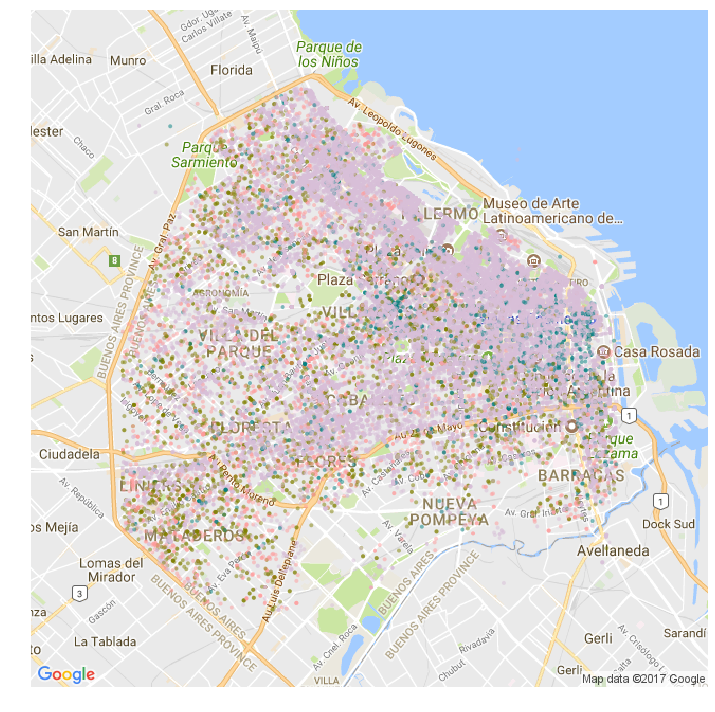

In [398]:
gm.scatter(latitudes=properties_scatter.lat,longitudes=properties_scatter.lon,colors=properties_scatter.color)

In [399]:
other_frame = properties_scatter.append(df)

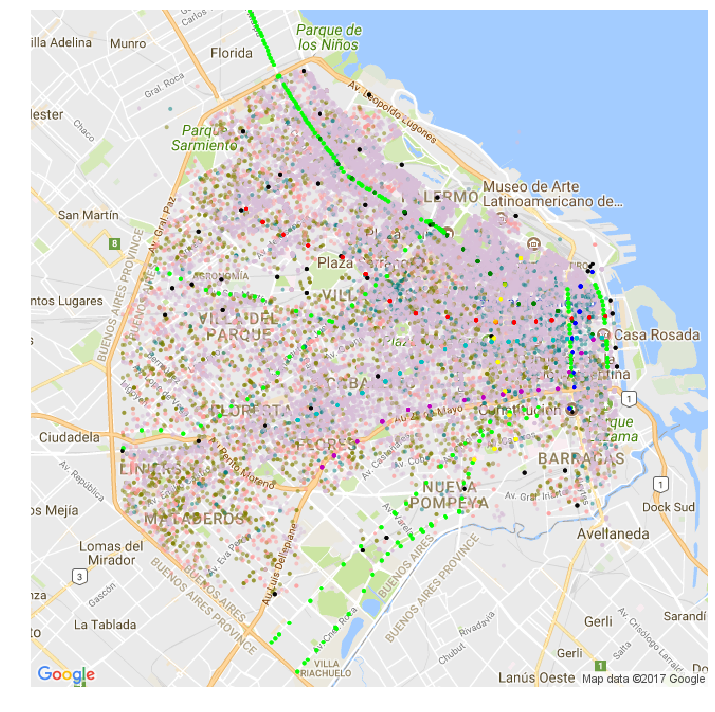

In [400]:
gm.scatter(latitudes=other_frame.lat, longitudes=other_frame.lon,colors=other_frame.color)

In [ ]:
gm.density_plot(latitudes=properties.lat, longitudes=properties.lon)